## 모델 데이타 DB 저장 및 로드 테스트



#### 1. 태양 흑점 데이터를 불러와 시각화하세요.


아래 코드로 1700~2008년의 흑점 수 데이터를 불러오세요.  
이동 평균을 추가해 데이터를 시각화하고,  
`seasonal_decompose`를 이용해 **period=11**로 시계열 요소로 분해 후 시각화하세요.
<pre>
import statsmodels.api as sm

df = sm.datasets.sunspots.load_pandas().data
</pre>

In [1]:
# 태양 흑점 데이터셋을 불러오는 코드
import statsmodels.api as sm
df = sm.datasets.sunspots.load_pandas().data


In [2]:
import pandas as pd

df['YEAR'] = pd.to_datetime(df['YEAR'], format='%Y')
df.set_index('YEAR', inplace=True)
df = df.loc['1700':'2008']

In [3]:
result = sm.tsa.seasonal_decompose(df['SUNACTIVITY'], model='additive', period=11)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 309 entries, 1700-01-01 to 2008-01-01
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   SUNACTIVITY  309 non-null    float64
dtypes: float64(1)
memory usage: 4.8 KB


In [5]:
df.index.year

Index([1700, 1701, 1702, 1703, 1704, 1705, 1706, 1707, 1708, 1709,
       ...
       1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008],
      dtype='int32', name='YEAR', length=309)

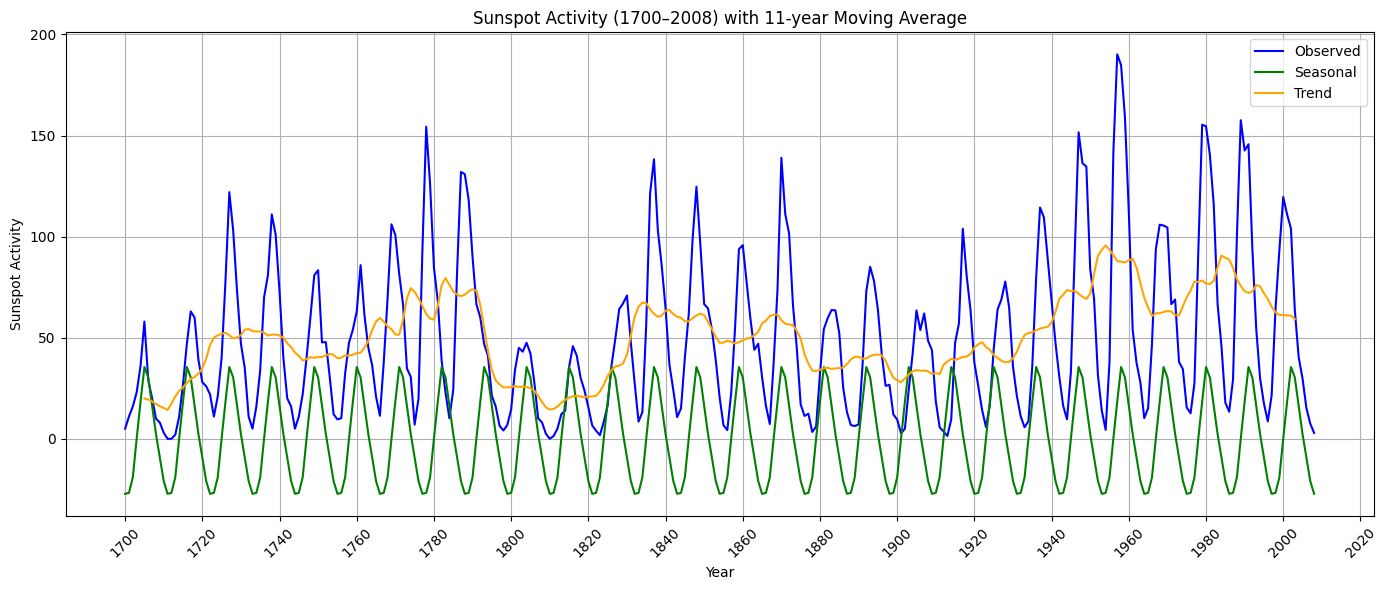

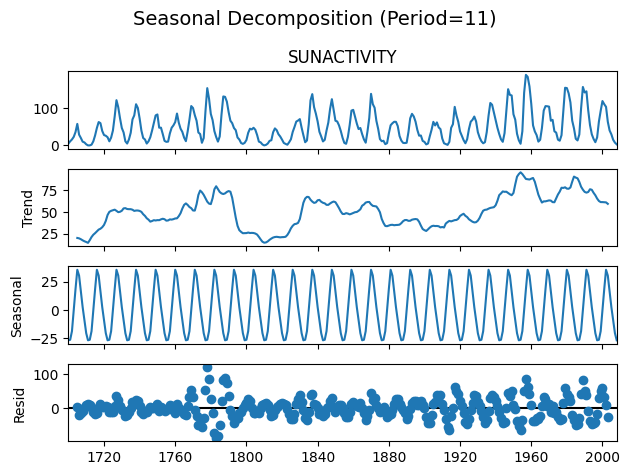

In [6]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, YearLocator

# 그림과 축 생성
fig, ax = plt.subplots(figsize=(14, 6))

# 선형 그래프
# ax.plot(df.index, df['SUNACTIVITY'], color='black', label='original')
# ax.plot(df.index, df['MA_11'], color='red', label='11-year MA')
ax.plot(df.index, result.observed, color='blue', label='Observed')
ax.plot(df.index, result.seasonal, color='green', label='Seasonal')
ax.plot(df.index, result.trend, color='orange', label='Trend')

# 눈금 설정: 20년 간격, 연도 형식
ax.xaxis.set_major_locator(YearLocator(20))  # 20년 단위 눈금
ax.xaxis.set_major_formatter(DateFormatter('%Y'))  # YYYY 형식

# 레이블, 제목
ax.set_xlabel('Year')
ax.set_ylabel('Sunspot Activity')
ax.set_title('Sunspot Activity (1700–2008) with 11-year Moving Average')

# 눈금 회전
plt.xticks(rotation=45)

# 범례, 그리드, 레이아웃
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

# seasonal decomposition 결과 시각화
result.plot()
plt.suptitle("Seasonal Decomposition (Period=11)", fontsize=14)
plt.tight_layout()
plt.show()

#### 2. ARIMA 모델로 예측하세요.

최근 10년의 흑점 수를 예측하기 위해 데이터를 훈련/테스트(최근 10년)로 분할하세요.  
ARIMA 또는 SARIMA 모델을 학습하고, 테스트 데이터에 대한 예측 성능을 **RMSE**로 확인하세요.

In [7]:
# 답안을 작성해주세요.
# 학습 / 테스트 데이터 분할
train = df[df.index.year <= 1998]
test = df[df.index.year > 1998]


In [8]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# 적합한 d 값을 찾기 위한 함수 정의
# ADF 테스트를 통해 정상성을 만족하는 차분 횟수를 찾는 함수
# 최대 차분 횟수는 5로 제한
# verbose=True로 설정하면 중간 결과를 출력
# 정상성을 만족하는 d 값을 반환
def find_optimal_d(series, max_d=5, verbose=True):
    """
    ADF 테스트를 반복하면서 정상성이 될 때까지 d를 증가
    :param series: 시계열 데이터 (Series 형태)
    :param max_d: 최대 차분 횟수 제한
    :param verbose: 중간 결과 출력 여부
    :return: 적절한 d 값
    """
    d = 0
    current_series = series.copy()

    while d <= max_d:
        result = adfuller(current_series.dropna())
        p_value = result[1]

        if verbose:
            print(f"d = {d} | ADF Statistic = {result[0]:.4f} | p-value = {p_value:.4f}")

        if p_value < 0.05:
            return d  # 정상성을 만족하는 d를 찾음

        # 그렇지 않으면 차분을 한 번 더 수행
        current_series = current_series.diff()
        d += 1

    # 최대 d를 초과했음 → 마지막 d 반환
    print("Warning: max_d 초과, 비정상성 잔존 가능")
    return d


In [9]:
d = find_optimal_d(train['SUNACTIVITY'], max_d=5, verbose=True)

d = 0 | ADF Statistic = -2.6584 | p-value = 0.0815
d = 1 | ADF Statistic = -14.6859 | p-value = 0.0000


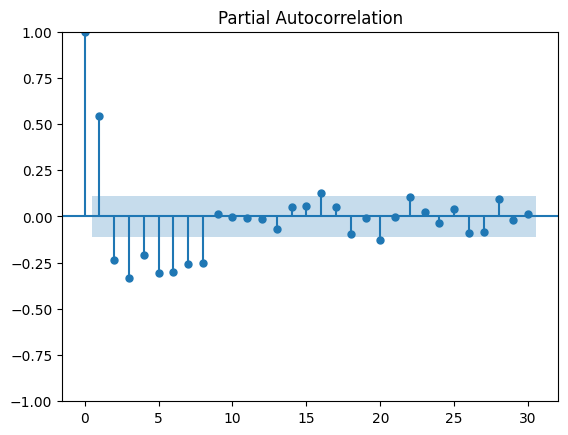

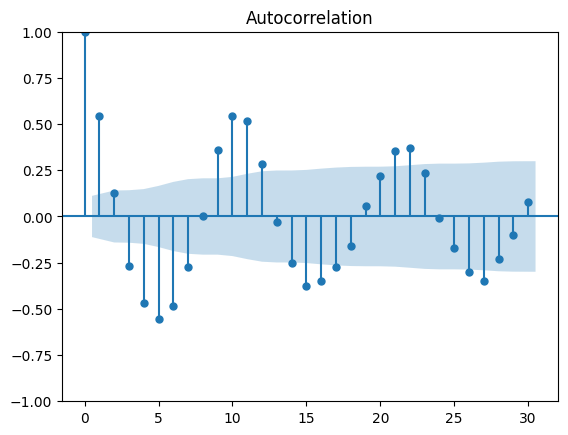

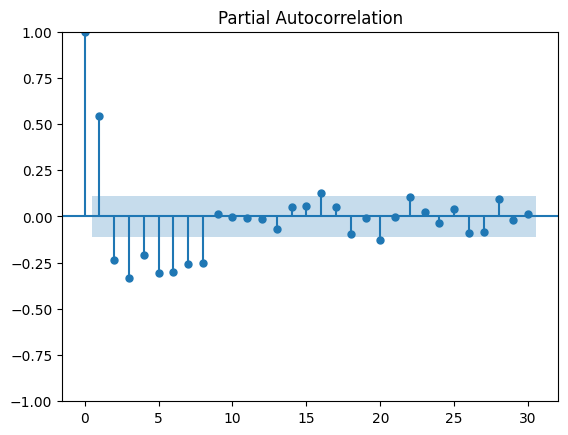

In [10]:
# p값과 q값을 결정하기 위한 ACF, PACF 플롯
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df['SUNACTIVITY'].diff().dropna(), lags=30)   # q 결정용
plot_pacf(df['SUNACTIVITY'].diff().dropna(), lags=30)  # p 결정용

In [26]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA

# ARIMA 모델 정의 및 학습
arima_model = ARIMA(train['SUNACTIVITY'], order=(8, d, 0))  # (p,d,q) 설정
results = arima_model.fit()


/opt/anaconda3/envs/dlp/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dlp/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dlp/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


In [27]:
type(arima_model)

statsmodels.tsa.arima.model.ARIMA

In [28]:
type(results)

statsmodels.tsa.arima.model.ARIMAResultsWrapper

In [ ]:
import pandas as pd
from datetime import datetime
from sqlalchemy import create_engine, Table, Column, Integer, String, LargeBinary, Text, MetaData, DateTime
import json


with open('db-config.json') as f:
    config = json.load(f)

user = config['user']
password = config['password']
host = config['host']
port = config['port']
database = config['database']

engine = create_engine(f"mysql+pymysql://{user}:{password}@{host}:{port}/{database}")


### ARIMA 모델 저장 코드

In [ ]:
## 모델 저장 코드입니다.
import pickle   ## 아리마 모델 저장을 위해.

## 아리마 모델..

model_blob = pickle.dumps(results)

metadata = MetaData()
models_table = Table(
    "models", metadata,
    Column("id", Integer, primary_key=True, autoincrement=True),
    Column("name", String(100), nullable=False),
    Column("type", String(100), nullable=False),
    Column("version", String(50)),
    Column("description", Text),
    Column("created_at", DateTime, default=datetime.utcnow),
    Column("data", LargeBinary, nullable=False)
)

with engine.connect() as conn:
    insert_stmt = models_table.insert().values(
        name="pm10_성북구_model",
        type="ARIMA",
        version="n1.01.250701",
        description="ARIMA(1,1,1) 시계열 모델",
        created_at=datetime.utcnow(),
        data=model_blob
    )
    conn.execute(insert_stmt)
    conn.commit()

### 아리마 모델 로드 코드

In [ ]:
# 아리마 모델 가져오기..
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults

#loaded_model = 
with engine.connect() as conn:
    result = conn.execute(models_table.select().where(models_table.c.name == "sunactivity_model"))
    row = result.fetchone()
    if row:
        loaded_model = pickle.loads(row.data)

# 예측 수행
arima_forecast = loaded_model.forecast(steps=len(test))

In [31]:
type(loaded_model)

statsmodels.tsa.arima.model.ARIMAResultsWrapper

Test RMSE: 19.22


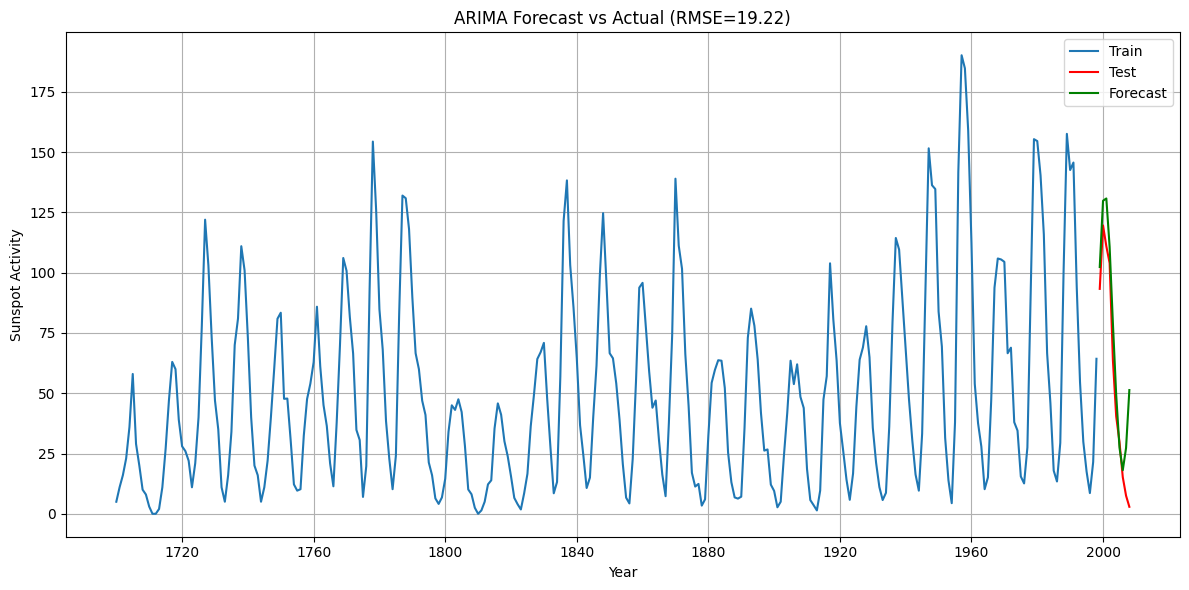

In [33]:
# 예측 수행
arima_forecast = loaded_model.forecast(steps=len(test))

# RMSE 계산
rmse = sqrt(mean_squared_error(test['SUNACTIVITY'], arima_forecast))
print(f"Test RMSE: {rmse:.2f}")

# 예측 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['SUNACTIVITY'], label='Train')
plt.plot(test.index, test['SUNACTIVITY'], label='Test', color='red')
plt.plot(test.index, arima_forecast, label='Forecast', color='green')
plt.title(f"ARIMA Forecast vs Actual (RMSE={rmse:.2f})")
plt.xlabel('Year')
plt.ylabel('Sunspot Activity')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

/opt/anaconda3/envs/dlp/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/dlp/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/dlp/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/dlp/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/dlp/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and w

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2835.116, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2730.690, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2743.278, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2833.116, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2714.956, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=2680.502, Time=0.04 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=2668.620, Time=0.08 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=2639.851, Time=0.10 sec


/opt/anaconda3/envs/dlp/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/dlp/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(6,1,0)(0,0,0)[0] intercept   : AIC=2610.819, Time=0.11 sec
 ARIMA(7,1,0)(0,0,0)[0] intercept   : AIC=2589.561, Time=0.13 sec


/opt/anaconda3/envs/dlp/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/dlp/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(8,1,0)(0,0,0)[0] intercept   : AIC=2566.640, Time=0.16 sec


/opt/anaconda3/envs/dlp/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(9,1,0)(0,0,0)[0] intercept   : AIC=2568.503, Time=0.34 sec


/opt/anaconda3/envs/dlp/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(8,1,1)(0,0,0)[0] intercept   : AIC=2568.465, Time=0.36 sec


/opt/anaconda3/envs/dlp/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(7,1,1)(0,0,0)[0] intercept   : AIC=2572.411, Time=0.23 sec


/opt/anaconda3/envs/dlp/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(9,1,1)(0,0,0)[0] intercept   : AIC=2570.115, Time=0.59 sec
 ARIMA(8,1,0)(0,0,0)[0]             : AIC=2564.714, Time=0.14 sec


/opt/anaconda3/envs/dlp/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/dlp/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(7,1,0)(0,0,0)[0]             : AIC=2587.586, Time=0.12 sec
 ARIMA(9,1,0)(0,0,0)[0]             : AIC=2566.583, Time=0.14 sec


/opt/anaconda3/envs/dlp/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/dlp/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(8,1,1)(0,0,0)[0]             : AIC=2566.547, Time=0.19 sec
 ARIMA(7,1,1)(0,0,0)[0]             : AIC=2570.526, Time=0.23 sec


/opt/anaconda3/envs/dlp/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/dlp/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(9,1,1)(0,0,0)[0]             : AIC=2568.197, Time=0.53 sec

Best model:  ARIMA(8,1,0)(0,0,0)[0]          
Total fit time: 3.595 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  309
Model:               SARIMAX(8, 1, 0)   Log Likelihood               -1273.357
Date:                Mon, 23 Jun 2025   AIC                           2564.714
Time:                        01:08:34   BIC                           2598.285
Sample:                    01-01-1700   HQIC                          2578.138
                         - 01-01-2008                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1896      0.045      4.173      0.000       0.101 

/opt/anaconda3/envs/dlp/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/dlp/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


ARIMA RMSE: 19.22


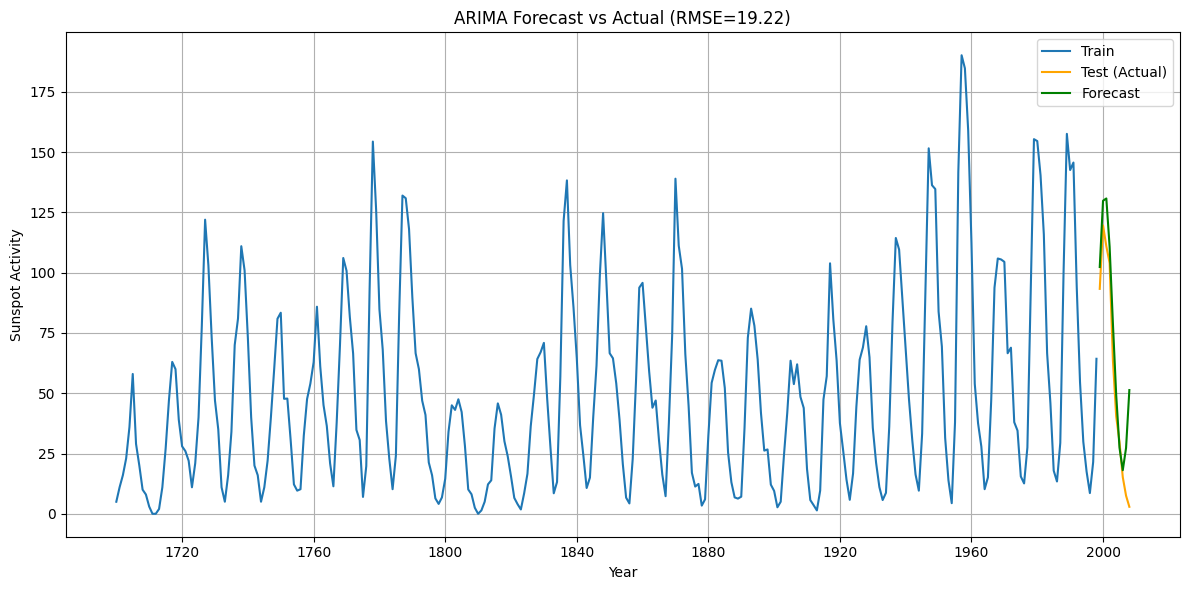

In [137]:
# Auto ARIMA 모델을 사용하여 최적의 (p, d, q) 조합을 찾고, 이를 이용한 예측 진행
from pmdarima.arima import auto_arima

auto_arima_model = auto_arima(
    df['SUNACTIVITY'], 
    start_p=0, start_q=0,
    max_p=10, max_q=10, 
    seasonal=False,
    d=None,              # 자동으로 차분 횟수 결정
    trace=True,
    error_action='ignore',  
    suppress_warnings=True,
    stepwise=True
)

print(auto_arima_model.summary())

auto_arima_model.fit(train['SUNACTIVITY'])

# 예측 (test 기간 길이만큼)
auto_arima_forecast = auto_arima_model.predict(n_periods=len(test))
auto_arima_forecast_index = test.index

# RMSE 계산
auto_ariam_rmse = sqrt(mean_squared_error(test['SUNACTIVITY'], auto_arima_forecast))
print(f"ARIMA RMSE: {rmse:.2f}")

# 시각화
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['SUNACTIVITY'], label='Train')
plt.plot(test.index, test['SUNACTIVITY'], label='Test (Actual)', color='orange')
plt.plot(auto_arima_forecast_index, auto_arima_forecast, label='Forecast', color='green')
plt.title(f"ARIMA Forecast vs Actual (RMSE={auto_ariam_rmse:.2f})")
plt.xlabel('Year')
plt.ylabel('Sunspot Activity')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

/opt/anaconda3/envs/dlp/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dlp/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


Test RMSE: 19.36


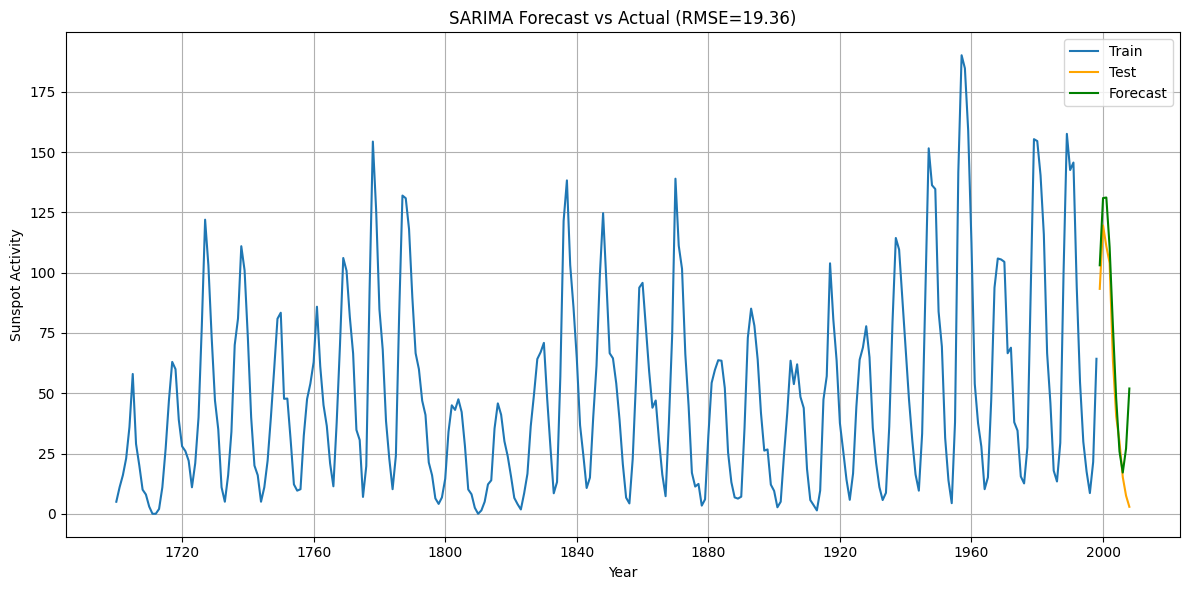

In [ ]:
# SARIMA 모델을 사용하여 태양 흑점 활동 예측
from statsmodels.tsa.statespace.sarimax import SARIMAX

# SARIMA 모델 정의 및 학습
model = SARIMAX(
    train['SUNACTIVITY'],
    order=(8, d, 0),
    seasonal_order=(1, 0, 1, 11),
    enforce_stationarity=False,
    enforce_invertibility=False
)
results = model.fit(disp=False)

# 예측 수행
forecast = results.forecast(steps=len(test))

# RMSE 계산
rmse = sqrt(mean_squared_error(test['SUNACTIVITY'], forecast))
print(f"Test RMSE: {rmse:.2f}")

# 예측 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['SUNACTIVITY'], label='Train')
plt.plot(test.index, test['SUNACTIVITY'], label='Test', color='orange')
plt.plot(test.index, forecast, label='Forecast', color='green')
plt.title(f"SARIMA Forecast vs Actual (RMSE={rmse:.2f})")
plt.xlabel('Year')
plt.ylabel('Sunspot Activity')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#### 3. LSTM 모델 예측을 위해 데이터 정규화와 분할하세요.

LSTM 모델로 최근 10년 흑점 수를 예측하기 위해 데이터를 정규화하세요.  

슬라이딩 윈도우 방식으로 입력 40년, 출력 10년의 (피처, 타겟) 쌍을 생성하세요.  
예시: (0\~39, 40\~49), (1\~40, 41\~50), (2\~41, 42\~51), ...

**최근 10년이 예측 대상이 되도록**, 해당 시점 이후의 시퀀스만 테스트셋으로 사용하세요.  
훈련 데이터의 피처와 타겟 배열의 shape을 출력하세요.

In [34]:
# 답안을 작성해주세요.
from sklearn.preprocessing import MinMaxScaler

# 학습 데이터와 테스트 데이터로 분할
data = df['SUNACTIVITY'].values.reshape(-1, 1)

# 정규화 (Min-Max Scaling)
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# 슬라이딩 윈도우 설정
INPUT_LEN = 40
OUTPUT_LEN = 10


In [35]:
X, y = [], []

# 슬라이딩 윈도우를 사용하여 입력과 출력 시퀀스 생성
# X는 입력 시퀀스, y는 출력 시퀀스
# X는 (샘플 수, 40, 1) 형태, y는 (샘플 수, 10, 1) 형태
for i in range(len(data_scaled) - INPUT_LEN - OUTPUT_LEN + 1):
    x_seq = data_scaled[i : i + INPUT_LEN]
    y_seq = data_scaled[i + INPUT_LEN : i + INPUT_LEN + OUTPUT_LEN]
    X.append(x_seq)
    y.append(y_seq)

X = np.array(X)  # shape: (샘플 수, 40, 1)
y = np.array(y)  # shape: (샘플 수, 10, 1)

In [36]:
len(data_scaled), len(X), len(y)

(309, 260, 260)

In [37]:
# 최근 10년 이후의 데이터가 에측 대상이므로 마지박 1 개를 테스트 데이터로 분리
X_train = X[:-1]
y_train = y[:-1]
X_test = X[-1:]
y_test = y[-1:]

# 5. 출력
print("** X_train.shape :", X_train.shape)  # (샘플 수, 40, 1)
print("** y_train.shape :", y_train.shape)  # (샘플 수, 10, 1)
print("** X_test.shape  :", X_test.shape)
print("** y_test.shape  :", y_test.shape)

** X_train.shape : (259, 40, 1)
** y_train.shape : (259, 10, 1)
** X_test.shape  : (1, 40, 1)
** y_test.shape  : (1, 10, 1)


#### 4. LSTM 모델로 예측하세요.

훈련 데이터를 이용해 LSTM 모델을 학습하고, 테스트 데이터에 대한 예측 결과의 **RMSE**를 계산하세요.

In [38]:
# 답안을 작성해주세요.
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from math import sqrt

# 하이퍼파라미터
input_len = X_train.shape[1]   # = 40 (입력 시퀀스 길이)
output_len = y_train.shape[1]  # = 10 (출력 시퀀스 길이)
feature_dim = X_train.shape[2] # = 1

# 모델 정의
lstm_model = Sequential([
    LSTM(64, activation='tanh', return_sequences=False, input_shape=(input_len, feature_dim)),
    Dense(32, activation='relu'),
    Dense(output_len)  # 다중 시계열 예측 (10년)
])

# 컴파일 및 학습
lstm_model.compile(optimizer='adam', loss='mse')
history = lstm_model.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.1, verbose=1)


2025-07-01 13:45:27.649445: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-07-01 13:45:27.649620: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2025-07-01 13:45:27.649628: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2025-07-01 13:45:27.649856: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-07-01 13:45:27.649870: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/opt/anaconda3/envs/dlp/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequentia

Epoch 1/100


2025-07-01 13:45:28.535412: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - loss: 0.0905 - val_loss: 0.0795
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0417 - val_loss: 0.0722
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0414 - val_loss: 0.0756
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0385 - val_loss: 0.0703
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0394 - val_loss: 0.0702
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0368 - val_loss: 0.0673
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0358 - val_loss: 0.0633
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0353 - val_loss: 0.0574
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0332 - val_loss: 0.0516
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0285 - val_loss: 0.0404
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0311 - val_loss: 0.0343
Epoch 12/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.

### LSTM 모델 저장 코드

In [45]:
import io
import h5py
import tempfile
from keras.models import load_model

# 모델을 메모리(HDF5 형식)로 저장
model_buffer = io.BytesIO()

with tempfile.NamedTemporaryFile(suffix=".h5", delete=True) as tmp:
    lstm_model.save(tmp.name)  # Keras 3: 반드시 .h5 확장자 사용
    tmp.seek(0)
    model_binary = tmp.read()  # 🔁 DB에 저장할 binary

#with h5py.File(model_buffer, 'w') as f:
#    lstm_model.save(f)  # save_format 제거됨 (Keras 3 호환)

#model_binary = model_buffer.getvalue()  # bytes

metadata = MetaData()
models_table = Table(
    "models", metadata,
    Column("id", Integer, primary_key=True, autoincrement=True),
    Column("name", String(100), nullable=False),
    Column("type", String(100), nullable=False),
    Column("version", String(50)),
    Column("description", Text),
    Column("created_at", DateTime, default=datetime.utcnow),
    Column("data", LargeBinary, nullable=False)
)

with engine.connect() as conn:
    insert_stmt = models_table.insert().values(
        name="sunactivity_model",
        type="LSTM",
        version="v1.0",
        description="LSTM 시계열 모델",
        created_at=datetime.utcnow(),
        data=model_binary
    )
    conn.execute(insert_stmt)
    conn.commit()


### LSTM 모델 로드 코드

In [61]:
from keras.models import load_model
from keras.losses import MeanSquaredError

with engine.connect() as conn:
    result = conn.execute(
        models_table.select().where(
            (models_table.c.name == 'sunactivity_model') &
            (models_table.c.type == 'LSTM')
        )
    ).mappings().fetchone()  # ✅ dict-like row 반환
    model_binary = result['data']

with tempfile.NamedTemporaryFile(suffix=".h5", delete=True) as tmp:
    tmp.write(model_binary)
    tmp.flush()
    loaded_model = load_model(tmp.name,
        custom_objects={'mse': MeanSquaredError()}
    )
lstm_model = loaded_model

In [62]:
# 예측
lstm_pred = lstm_model.predict(X_test)

# RMSE 계산
lstm_rmse = sqrt(mean_squared_error(y_test.flatten(), lstm_pred.flatten()))
print(f"LSTM RMSE: {lstm_rmse:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 998ms/step
LSTM RMSE: 0.07


#### 5. 최근 10년 흑점 수 예측 결과를 시각화하세요.

ARIMA와 LSTM 모델이 예측한 **최근 10년간 흑점 수**를 실제 관측값과 함께 한 그래프에 시각화하세요.

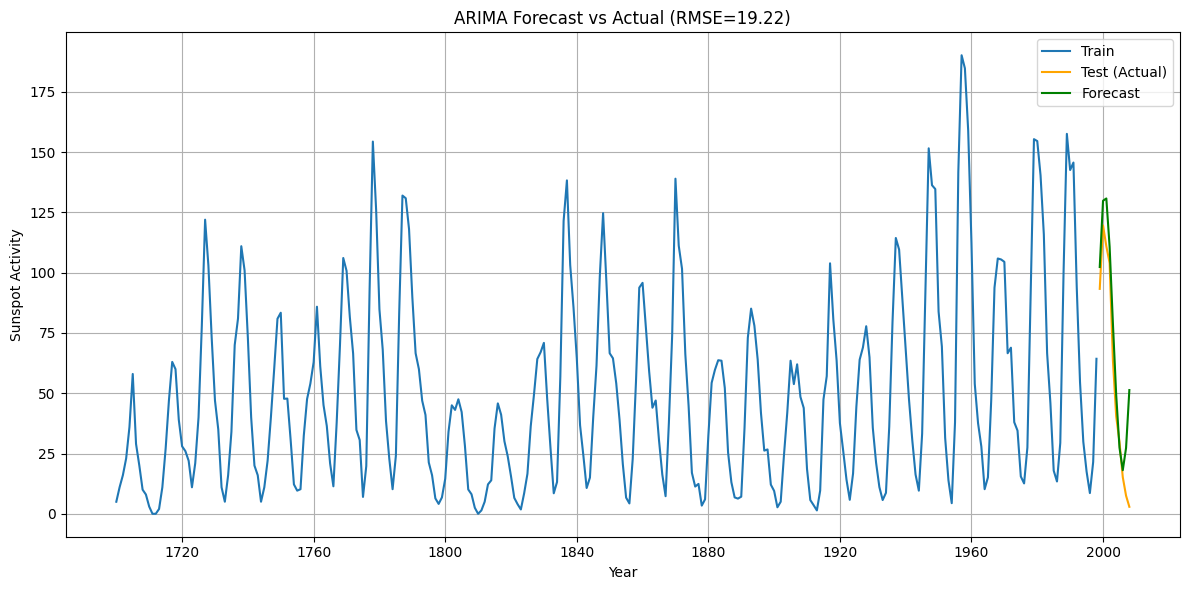

/var/folders/5k/zrsrnd7s18b7z_zm0b5yktj40000gn/T/ipykernel_60772/3601197495.py:23: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  test_years = pd.date_range(start='1999', periods=10, freq='Y')  # 1999~2008


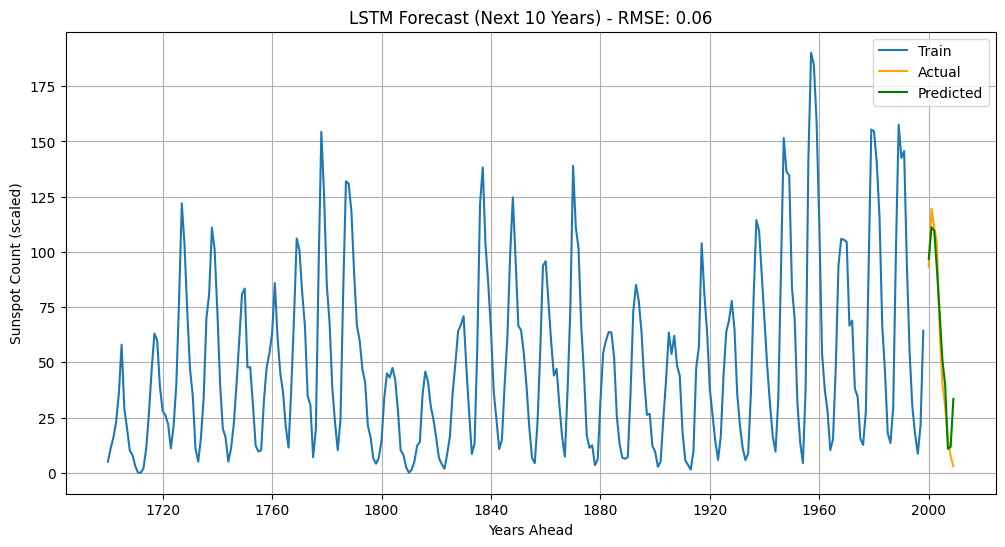

In [148]:
# ARIMA 예측 시각화
# 위 auto_arima 예측 결과를 사용하여 시각화

plt.figure(figsize=(12, 6))
plt.plot(train.index, train['SUNACTIVITY'], label='Train')
plt.plot(test.index, test['SUNACTIVITY'], label='Test (Actual)', color='orange')
plt.plot(auto_arima_forecast_index, auto_arima_forecast, label='Forecast', color='green')
plt.title(f"ARIMA Forecast vs Actual (RMSE={auto_ariam_rmse:.2f})")
plt.xlabel('Year')
plt.ylabel('Sunspot Activity')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# LSTM 예측 결과 시각화

# 훈련 데이터 (정규화 해제)
train_years = df[df.index.year <= 1998].index  # 1700~1998
train_data = df[df.index.year <= 1998]['SUNACTIVITY']  #scaler.inverse_transform(data_scaled[:len(train_years)]).flatten()

# 예측 데어터 (정휴화 해제)
test_years = pd.date_range(start='1999', periods=10, freq='Y')  # 1999~2008
y_actual_unscaled = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_unscaled = scaler.inverse_transform(lstm_pred.reshape(-1, 1)).flatten()

plt.figure(figsize=(12, 6))
plt.plot(train_years, train_data, label='Train')
plt.plot(test_years, y_actual_unscaled.flatten(), label='Actual', color='orange')
plt.plot(test_years, y_pred_unscaled.flatten(), label='Predicted', color='green')
plt.title(f'LSTM Forecast (Next 10 Years) - RMSE: {lstm_rmse:.2f}')
plt.xlabel('Years Ahead')
plt.ylabel('Sunspot Count (scaled)')
plt.legend()
plt.grid(True)
plt.show()